In [196]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, r2_score
from sklearn.datasets import load_iris, make_moons
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

X, Y = load_iris().data, load_iris().target

In [238]:
class BaseRandomForest:
    "Base class for both classification and regression"
    
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, max_features='auto',
                 random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split=2
        self.max_features = max_features
        self.trees_feat_idx = []
        self.rng = np.random.RandomState(random_state)
    
    def _get_max_features(self, X):
        """
        Method is used for calculating number of max features used
        for predicting for one tree. There are a lot of different ways
        to calculate that. Most popular method (recommended in original
        paper) is sqrt(max_features). Additionally you can set just
        a number.
        
        Parameters
        ----------
        X : DataFrame
            Features for modelling
        
        Returns
        -------
        int
            number of features to take from X.
        """
        n_features = X.shape[1]
        if self.max_features == 'auto':
            return int(np.sqrt(n_features))
        elif isinstance(self.max_features, int):
            return self.max_features
        else:
            raise ValueError('Bad max features')
            
    def get_subset(self, X, Y):
        """
        When you use random forest algorithms it is important to use
        different subsets for traing trees. Doing that helps to 
        lower correlation between trees and as a result it decrease
        variance of the model.
        
        Parameters
        ----------
        X : DataFrame
            Features for modelling
        Y : Series
            targets
            
        Returns
        -------
        list
            subset of X and Y
        """
        m = X.shape[0]
        idx = self.rng.choice(range(m), 10)
        return X[idx], Y[idx]
        
        
    def fit(self, X, Y):
        self.trees = self._get_trees()
        max_feat = self._get_max_features(X)
        m = X.shape[0]
        
        for i in range(self.n_estimators):
            sub_X, sub_Y = self.get_subset(X, Y)
            idx_features = self.rng.choice(range(sub_X.shape[1]), max_feat, replace=True)
            self.trees_feat_idx.append(idx_features)
            temp_X = sub_X[:, idx_features]
            self.trees[i].fit(temp_X, sub_Y)
            
            
    def predict(self, X):
        y_preds = np.zeros(shape=(X.shape[0], self.n_estimators))
        for i in range(self.n_estimators):
            idx_features = self.trees_feat_idx[i]
            temp_X = X[:, idx_features]
            one_pred = self.trees[i].predict(temp_X)
            y_preds[:,i] = one_pred
        
        result = []
        for row in y_preds:
            pred = self._pred_from_row(row)
            result.append(pred)
        
        return result

    
class RandomForestClassifier(BaseRandomForest):
    def _get_trees(self):
        """
        Method creates trees used for classification. Hyperparameters for 
        all trees are the same and they have to be already set. Currently
        only max_depth and min_samples_split is used.
        
        Returns
        -------
        list
            Instances of DecisionTreeClassifiers 
            number of trees = self.n_estimators
        """
        trees = []
        for _ in range(self.n_estimators):
            trees.append(
                DecisionTreeClassifier(max_depth=self.max_depth, 
                                       min_samples_split=self.min_samples_split))
        return trees
    
    def _pred_from_row(self, row):
        """
        The prrediction for every row in data most common prediction. For example
        if we have 100 trees there are 100 predictions for every instance in
        dataset. The final prediction is one which is the most common.
        
        Parameters
        ----------
        list
            All predictions from trees for one instance
            
        Returns
        -------
        int
            The most common prediction.
        """
        return Counter(row).most_common(1)[0][0]

    
class RandomForestRegressor(RandomForestClassifier):
    def _get_trees(self):
        trees = []
        for _ in range(self.n_estimators):
            trees.append(
                DecisionTreeRegressor(max_depth=self.max_depth, 
                                       min_samples_split=self.min_samples_split))
        return trees
    
    def _pred_from_row(self, row):
        return np.mean(row)

### Visualization of Random Forest

Accuracy score: 88.3%


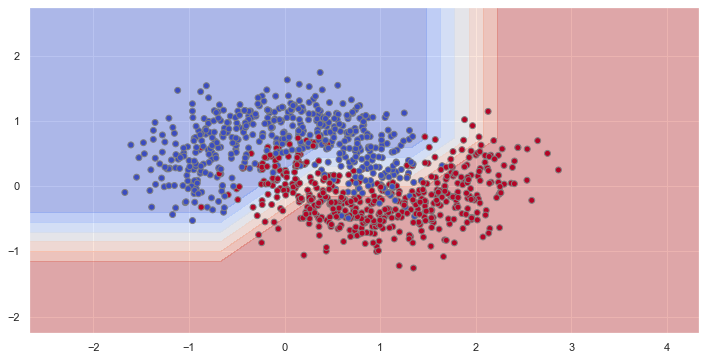

In [241]:
plt.figure(figsize=(12,6))
X, Y = make_moons(n_samples=1000, noise=0.3, random_state=42)
model = RandomForestClassifier(max_depth=5)
model.fit(X, Y)
Y_pred = model.predict(X)
acc_score = accuracy_score(Y, Y_pred)
print(f'Accuracy score: {acc_score * 100}%')
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 2
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.array(Z).reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.4)
plt.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm', edgecolor='gray');

0.8471207507192352


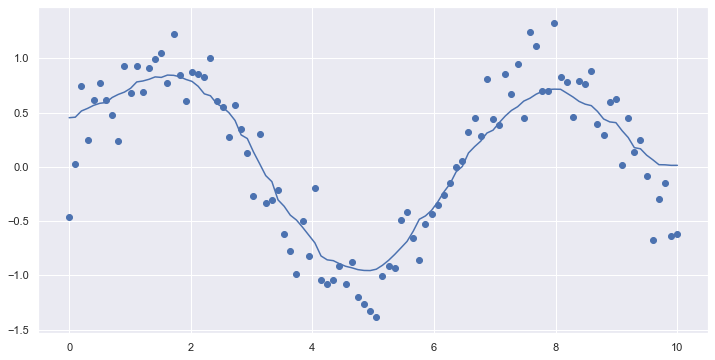

In [231]:
plt.figure(figsize=(12, 6))
X = np.linspace(0, 10, 100)
Y = np.sin(X) + np.random.randn(100) * 0.2
plt.scatter(X, Y)
model = RandomForestRegressor(max_depth=5)
model.fit(X.reshape(-1,1), Y)
Y_pred = model.predict(X.reshape(-1,1))
print(r2_score(Y, Y_pred))
plt.plot(X, Y_pred);

In [233]:
from sklearn.ensemble import RandomForestClassifier as rg_sklearn